<a href="https://colab.research.google.com/github/afif-af/ml_pytorch_scikitlearn/blob/main/Chapter07ml_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
  k_start=int(math.ceil(n_classifier/2.))
  probs=[comb(n_classifier, k) * error **k *
          (1-error)**(n_classifier -k)
          for k in range(k_start, n_classifier +1)]
  return sum(probs)


In [2]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

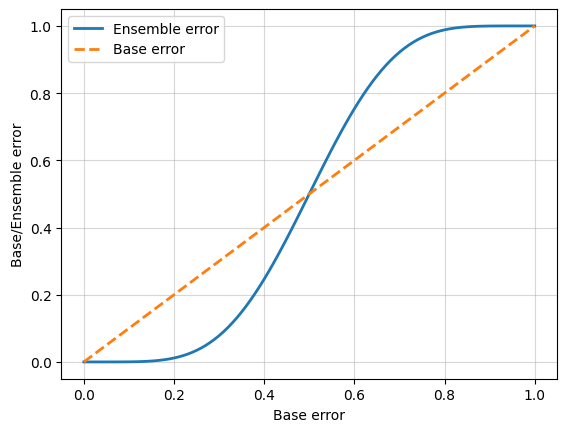

In [3]:

import numpy as np
import matplotlib.pyplot as plt
error_range=np.arange(0.0, 1.01, 0.01)
ens_errors =[ensemble_error(n_classifier=11, error=error)
             for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--',label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [5]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
             weights=[0.2,0.2,0.6]))



np.int64(1)

In [6]:
ex=np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])
p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [7]:
np.argmax(p)

np.int64(0)